In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import v2
from tqdm import tqdm

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda')
elif torch.backends.mps.is_available():
  device = torch.device('mps')
else:
  device = torch.device('cpu')

print("Using", device)

Using cuda


### Tensors


Moving between devices

In [ ]:
input_cpu = torch.linspace(0., 2. * torch.pi, steps=25, requires_grad=True)
print("Initial tensor location:", input_cpu.device)
input = input_cpu.to(device)
print("Tensor location after moving:", input.device)

Initial tensor location: cpu
Tensor location after moving: cuda:0


Tracking gradients

Tensor with gradient tracking: tensor([ 0.0000e+00,  2.5882e-01,  5.0000e-01,  7.0711e-01,  8.6603e-01,
         9.6593e-01,  1.0000e+00,  9.6593e-01,  8.6603e-01,  7.0711e-01,
         5.0000e-01,  2.5882e-01, -8.7423e-08, -2.5882e-01, -5.0000e-01,
        -7.0711e-01, -8.6603e-01, -9.6593e-01, -1.0000e+00, -9.6593e-01,
        -8.6603e-01, -7.0711e-01, -5.0000e-01, -2.5882e-01,  1.7485e-07],
       device='cuda:0', grad_fn=<SinBackward0>)

Tensor detached from computation graph: tensor([ 0.0000e+00,  2.5882e-01,  5.0000e-01,  7.0711e-01,  8.6603e-01,
         9.6593e-01,  1.0000e+00,  9.6593e-01,  8.6603e-01,  7.0711e-01,
         5.0000e-01,  2.5882e-01, -8.7423e-08, -2.5882e-01, -5.0000e-01,
        -7.0711e-01, -8.6603e-01, -9.6593e-01, -1.0000e+00, -9.6593e-01,
        -8.6603e-01, -7.0711e-01, -5.0000e-01, -2.5882e-01,  1.7485e-07])


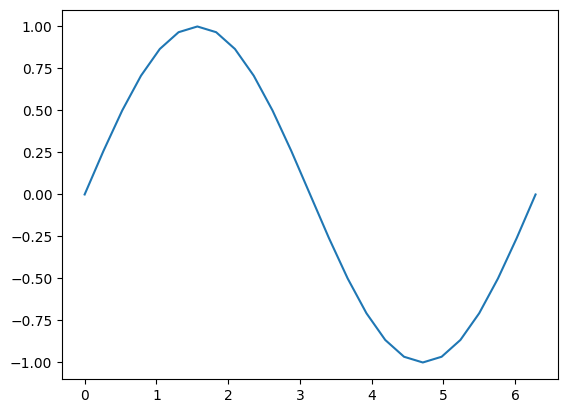

In [ ]:
sinusoid = torch.sin(input)
print("Tensor with gradient tracking:", sinusoid)
print("\nTensor detached from computation graph:", sinusoid.detach().to('cpu'))
plt.plot(input.detach().to('cpu'), sinusoid.detach().to('cpu'))

Computation graph will only store gradients of leaf nodes by default, since those are parameters are leaf nodes and we will only need their gradients w.r.t. loss for updates

In [ ]:
out = sinusoid.sum()
print(out)
print(input.grad_fn)
out.backward()
print(input.grad)
print("Gradients w.r.t. input:", input_cpu.grad)

tensor(2.3842e-07, device='cuda:0', grad_fn=<SumBackward0>)
None
Gradients w.r.t. input: tensor([ 1.0000e+00,  9.6593e-01,  8.6603e-01,  7.0711e-01,  5.0000e-01,
         2.5882e-01, -4.3711e-08, -2.5882e-01, -5.0000e-01, -7.0711e-01,
        -8.6603e-01, -9.6593e-01, -1.0000e+00, -9.6593e-01, -8.6603e-01,
        -7.0711e-01, -5.0000e-01, -2.5882e-01,  1.1925e-08,  2.5882e-01,
         5.0000e-01,  7.0711e-01,  8.6603e-01,  9.6593e-01,  1.0000e+00])


<ipython-input-5-2bab70447559>:5: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  print(input.grad)


### Building a simple neural network for digit recognition
We'll use the LeNet-5 CNN architecture from LeCun et al. (1998)
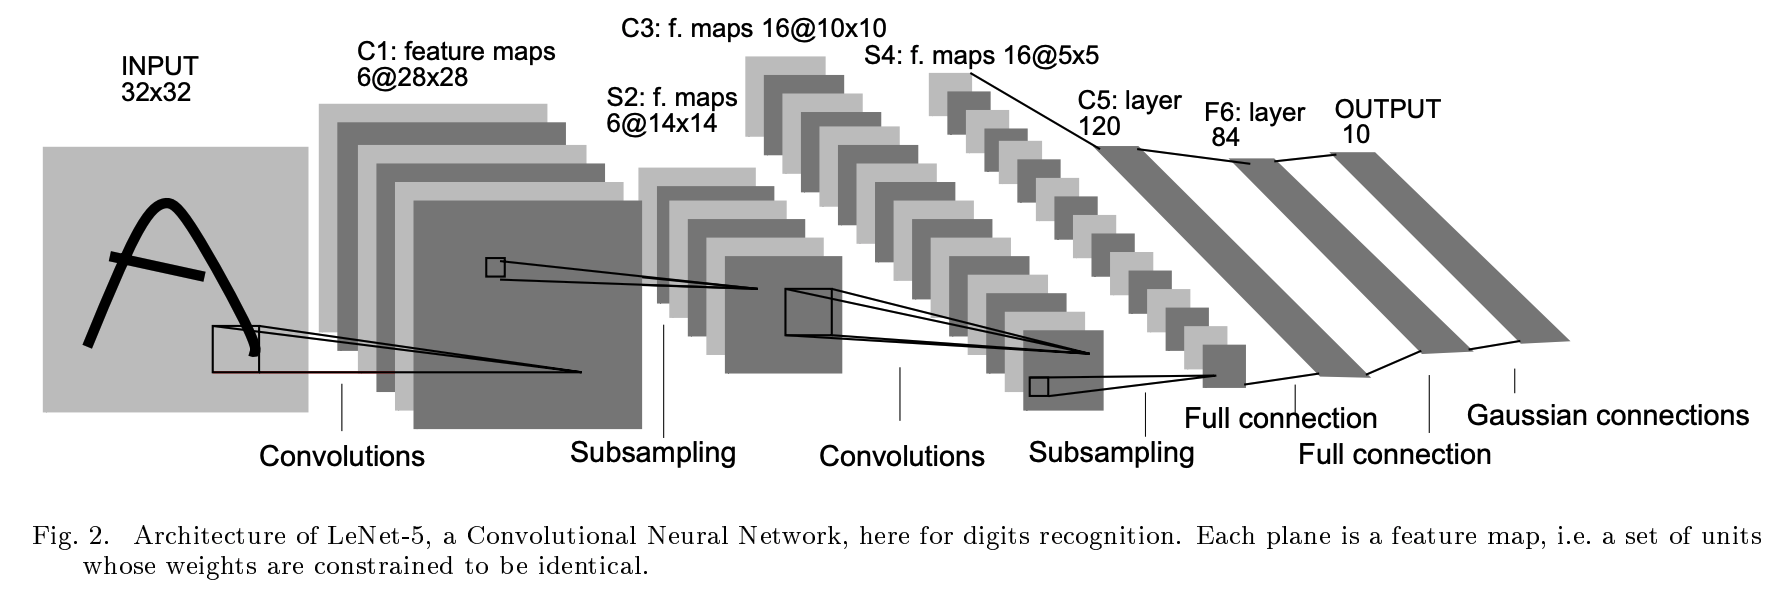

Implement the network architecture

In [ ]:
class LeNet5(nn.Module):
    """LeNet5 architecture for MNIST dataset, with the original subsampling layers replaced by AvgPool2d."""
    def __init__(self):
        super(LeNet5, self).__init__()

        # Declare some fixed parameters for LeNet
        num_filters_c1 = 6
        num_filters_c2 = 16
        num_in_channels = 1
        kernel_size = 5
        num_output_classes = 10

        # Declare your layers
        self.ConvLayer1 = nn.Sequential(
            nn.Conv2d(num_in_channels, num_filters_c1, kernel_size),  # 1x32x32 -> 6x28x28
            nn.AvgPool2d(2, stride=2),  # 6x28x28 -> 6x14x14
            nn.Sigmoid()
        )
        self.ConvLayer2 = nn.Sequential(
            nn.Conv2d(num_filters_c1, num_filters_c2, kernel_size, bias=False),  # 6x14x14 -> 16x10x10
            nn.AvgPool2d(2, stride=2),  # 16x10x10 -> 16x5x5
            nn.Sigmoid()
        )
        self.c5 = nn.Linear(16 * 5 * 5, 120)
        self.f6 = nn.Linear(120, 84)
        self.output = nn.Linear(84, num_output_classes)

    def forward(self, x):
        x = self.ConvLayer1(x)
        x = self.ConvLayer2(x)
        x = x.view(-1, 16 * 5 * 5)  # Maintain bsz dimension
        x = self.c5(x)
        x = self.f6(x)
        x = self.output(x)
        return x

Initialize your network and ensure that there are no shape mismatches.

In [ ]:
model = LeNet5().to(device)
print(model)
bsz = 5  # Batch size (bsz)
num_chans, height, width = 1, 32, 32  # Image dimensions
test_input = torch.randn(bsz, num_chans, height, width).to(device)
print(model(test_input).shape)  # (bsz, num_classes) - contains the raw logits per class

LeNet5(
  (ConvLayer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (2): Sigmoid()
  )
  (ConvLayer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (2): Sigmoid()
  )
  (c5): Linear(in_features=400, out_features=120, bias=True)
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (output): Linear(in_features=84, out_features=10, bias=True)
)
torch.Size([5, 10])


Declare your loss function and optimizer of choice.

In [ ]:
cel_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

### Load and prepare your dataset

In [ ]:
transform = v2.Compose([
    v2.ToImage(),
    v2.Pad(2),
    v2.ToDtype(torch.float32, scale=True)])

In [ ]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Split off a validation set from training data
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [50000, 10000], generator=torch.Generator().manual_seed(1))
X_train = train_subset.dataset.data[train_subset.indices]
y_train = train_subset.dataset.targets[train_subset.indices]

X_val = val_subset.dataset.data[val_subset.indices]
y_val = val_subset.dataset.targets[val_subset.indices]

100%|██████████| 9912422/9912422 [00:00<00:00, 93623807.05it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 109229660.80it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 45265809.22it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14476085.69it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
bsz = 256
train_loader = torch.utils.data.DataLoader(train_subset, shuffle=True, batch_size=bsz)
val_loader = torch.utils.data.DataLoader(val_subset, shuffle=False, batch_size=bsz)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=bsz)
print(len(train_loader), len(val_loader), len(test_loader))

196 40 40


In [ ]:
num_epochs = 10
for epoch_idx in tqdm(range(num_epochs)):
    # Set model to train mode - useful for layers such as BatchNorm or Dropout whose behaviors change between train/eval
    model.train()
    train_count = 0
    train_correct_count = 0
    for batch_idx, (train_x, train_y) in enumerate(train_loader):
        train_x = train_x.float().to(device)
        train_y = train_y.long().to(device)
        optimizer.zero_grad() # Zero gradients, since we don't want gradients to accumulate between batches - we apply an update for each batch
        logits = model(train_x)
        loss = cel_loss(logits, train_y)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_hat = torch.argmax(logits, dim=-1)
            train_correct_count += torch.sum(y_hat == train_y, axis=-1)
            train_count += train_x.size(0)

    train_acc = train_correct_count / train_count

    model.eval()
    val_count = 0
    val_correct_count = 0
    with torch.no_grad():
        for idx, (val_x, val_y) in enumerate(val_loader):
            val_x = val_x.float().to(device)
            val_y = val_y.long().to(device)
            logits = model(val_x).detach()
            y_hat = torch.argmax(logits, dim=-1)
            val_correct_count += torch.sum(y_hat == val_y, axis=-1)
            val_count += val_x.size(0)
    val_acc = val_correct_count / val_count

    print('Train acc: {:.3f}, Val acc: {:.3f}'.format(train_acc, val_acc))

 10%|█         | 1/10 [00:24<03:42, 24.69s/it]

Train acc: 0.355, Val acc: 0.787


 20%|██        | 2/10 [00:42<02:44, 20.58s/it]

Train acc: 0.866, Val acc: 0.887


 30%|███       | 3/10 [00:59<02:13, 19.03s/it]

Train acc: 0.914, Val acc: 0.931


 40%|████      | 4/10 [01:18<01:53, 18.91s/it]

Train acc: 0.938, Val acc: 0.940


 50%|█████     | 5/10 [01:35<01:31, 18.29s/it]

Train acc: 0.952, Val acc: 0.955


 60%|██████    | 6/10 [01:52<01:11, 17.99s/it]

Train acc: 0.958, Val acc: 0.961


 70%|███████   | 7/10 [02:11<00:54, 18.19s/it]

Train acc: 0.965, Val acc: 0.965


 80%|████████  | 8/10 [02:28<00:35, 17.91s/it]

Train acc: 0.966, Val acc: 0.971


 90%|█████████ | 9/10 [02:46<00:17, 17.93s/it]

Train acc: 0.969, Val acc: 0.971


100%|██████████| 10/10 [03:03<00:00, 18.37s/it]

Train acc: 0.970, Val acc: 0.967


In [ ]:
model.eval()
with torch.no_grad():
    test_count = 0
    test_correct_count = 0
    for idx, (test_x, test_y) in enumerate(test_loader):
        test_x = test_x.float().to(device)
        test_y = test_y.long().to(device)
        logits = model(test_x).detach()
        y_hat = torch.argmax(logits, dim=-1)
        test_correct_count += torch.sum(y_hat == test_y, axis=-1)
        test_count += test_x.size(0)
    test_acc = test_correct_count / test_count
    print('Test acc: {:.3f}'.format(test_acc))

Test acc: 0.972


In [ ]:
print(test_y, y_hat)

tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6], device='cuda:0') tensor([1, 2, 8, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6], device='cuda:0')


Prediction: 9 
True label: 9


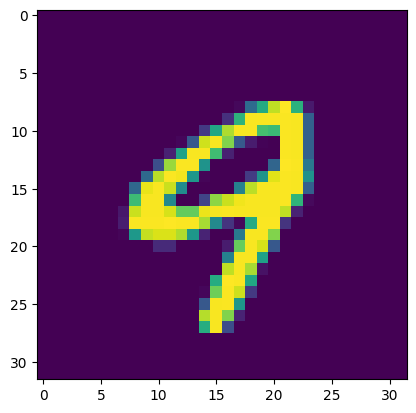

In [ ]:
example_idx = 8
plt.imshow(test_x[example_idx].cpu().detach().permute(1, 2, 0))
print(f"Prediction: {y_hat[example_idx]} \nTrue label: {test_y[example_idx]}")